# Annotation mapping

In this example, we show how to use {func}`moscot.problems.space.annotation_mapping`.

:::{seealso}
- See {doc}`200_cell_transitions` on how to compute and plot cell transitions.
:::

## Imports and data loading

In [1]:
import warnings

from tqdm import TqdmWarning

warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

import moscot as mt
from moscot import datasets
from moscot.problems.space import MappingProblem

import numpy as np

import seaborn as sns

import scanpy as sc

Load the {func}`~moscot.datasets.drosophila` dataset.

In [2]:
adata_sc = datasets.drosophila(spatial=False)
adata_sp = datasets.drosophila(spatial=True)
sc.pp.subsample(adata_sc, 0.1)  # subsample for speed
sc.pp.subsample(adata_sp, 0.1)
adata_sc, adata_sp

(AnnData object with n_obs × n_vars = 129 × 2000
     obs: 'n_counts'
     var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg', 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 303 × 82
     obs: 'n_counts'
     var: 'n_counts'
     uns: 'log1p', 'pca'
     obsm: 'X_pca', 'spatial'
     varm: 'PCs'
     layers: 'counts')

## Cluster the data

In [3]:
sc.pp.neighbors(adata_sc)
sc.pp.neighbors(adata_sp)

In [4]:
sc.tl.umap(adata_sc)
sc.tl.umap(adata_sp)

In [5]:
sc.tl.leiden(adata_sc, resolution=0.57)  # low resolution
sc.tl.leiden(adata_sp, resolution=0.57)

In [6]:
adata_sc.obs.leiden = adata_sc.obs.leiden.astype("category")
adata_sp.obs.leiden = adata_sp.obs.leiden.astype("category")

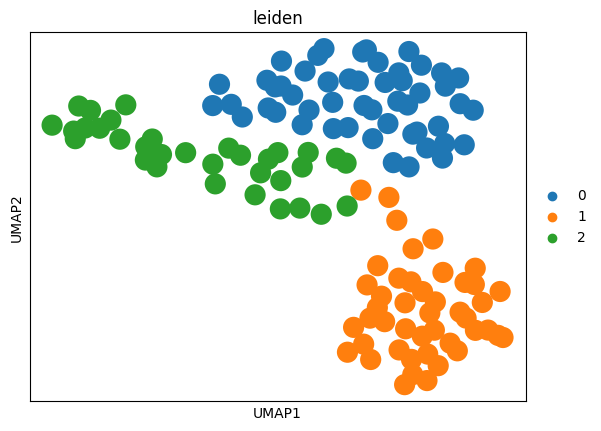

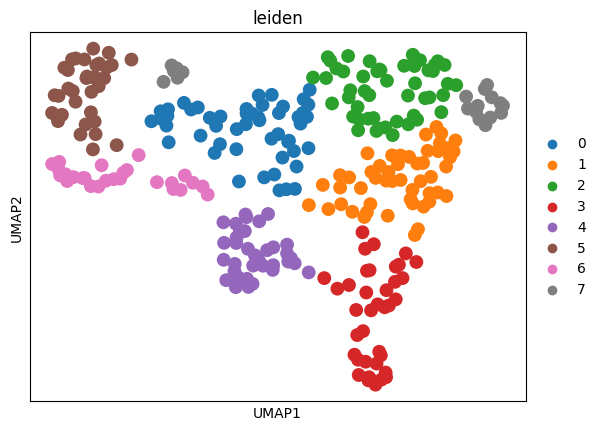

In [7]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color="leiden")

## Prepare and solve the problem

In [8]:
mp = MappingProblem(adata_sc=adata_sc, adata_sp=adata_sp)

In [9]:
mp = mp.prepare(
    sc_attr={"attr": "obsm", "key": "X_pca"}, kwargs={"callback_kwargs": "local_pca"}
).solve()

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(303, 129)].                                            


Create the annotation mapping of leiden clusters from `adata_sc` to `adata_sp`.

First, we create the annotation mapping using "max" mode.

In [10]:
anno_map_max = mp.annotation_mapping(
    "max",
    "leiden",
    source="src",
)
adata_sp.obs["leiden_max"] = anno_map_max["leiden"].values
adata_sp.obs["leiden_max"] = adata_sp.obs["leiden_max"].astype("category")

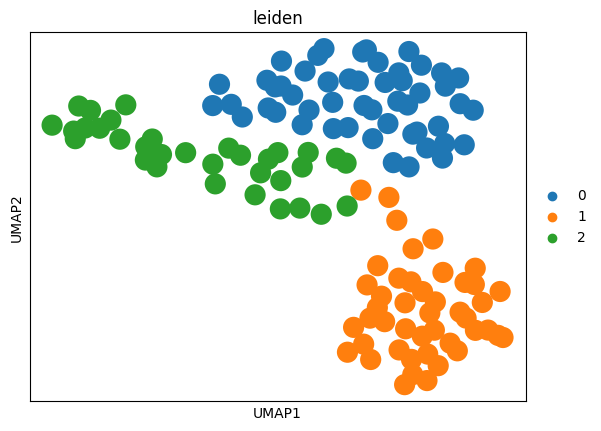

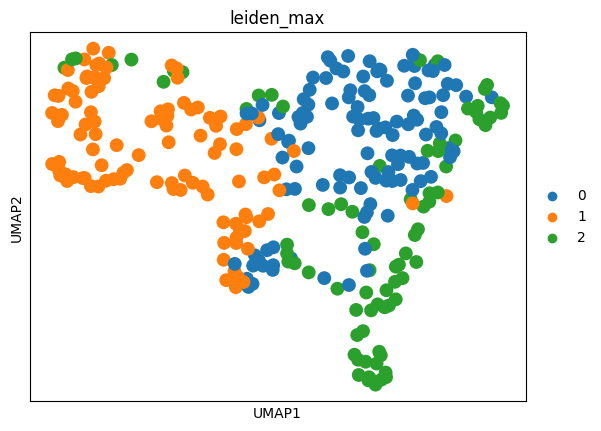

In [11]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color=["leiden_max"])

Then, we create the annotation mapping using "sum" mode.

In [12]:
anno_map_sum = mp.annotation_mapping(
    "sum",
    "leiden",
    source="src",
    forward=True,
    cell_transition_kwargs=dict(
        batch_size=512,
    ),
)
adata_sp.obs["leiden_sum"] = anno_map_sum["leiden"].values
adata_sp.obs["leiden_sum"] = adata_sp.obs["leiden_sum"].astype("category")

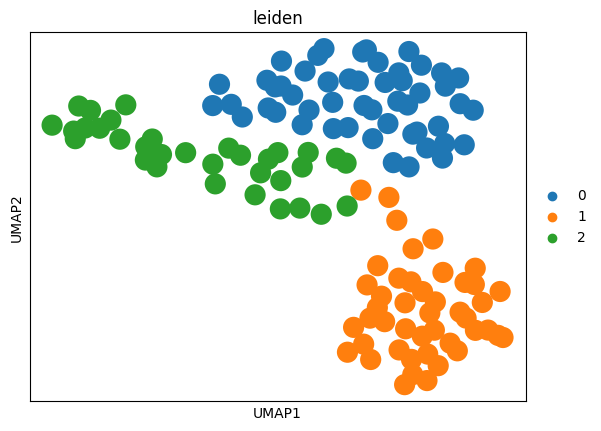

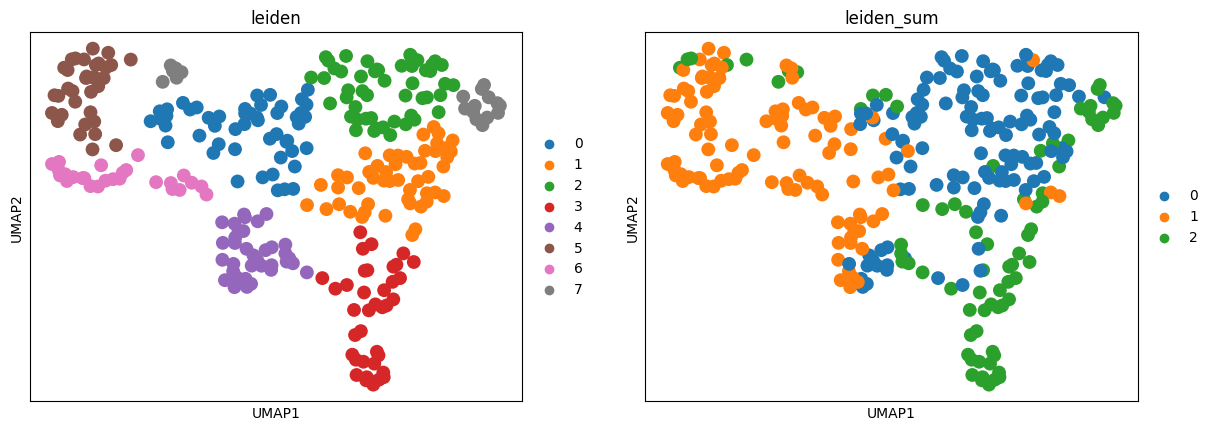

In [13]:
sc.pl.umap(adata_sc, color="leiden")
sc.pl.umap(adata_sp, color=["leiden", "leiden_sum"])

Compare the resulting mapping of different modes:

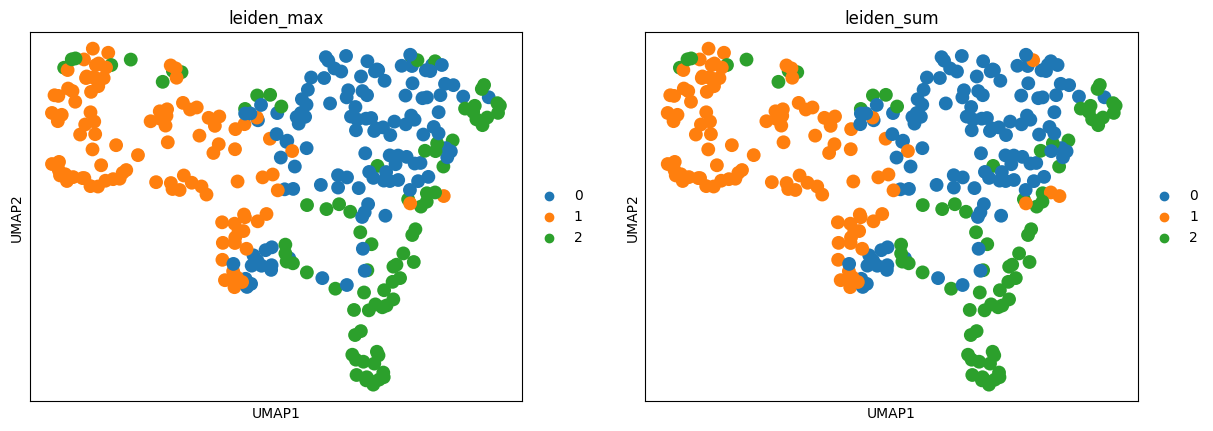

In [14]:
sc.pl.umap(adata_sp, color=["leiden_max", "leiden_sum"])